In [ ]:
import SimpleITK as sitk
from subprocess import Popen
import subprocess
import SimpleITK as sitk
import pandas as pd
import multiprocessing as mp
import functools
from functools import partial
import sys
import os.path
from os import path as pathOs
import numpy as np
import tempfile
import shutil
from os.path import basename, dirname, exists, isdir, join, split
from pathlib import Path
import fileinput
import re
import subprocess
from toolz.itertoolz import groupby
import seaborn as sns
import einops
import matplotlib.pyplot as plt
import itertools
import SimpleITK as sitk
import mdai
import pandas as pd
import numpy as np
import cv2
import pydicom
import os
import multiprocessing as mp
import functools
from functools import partial
import mdai
import math
import time
import itertools
from pydicom.fileset import FileSet
from os import path as pathOs
from pathlib import Path
import toolz
from toolz.curried import pipe, map, filter, get
from toolz import curry
from os.path import basename, dirname, exists, isdir, join, split
import nnunetv2

import elastixRegister as elastixRegister
from elastixRegister import reg_a_to_b
import tempfile
import shutil
import re
from toolz.itertoolz import groupby
from toolz import curry
# import multiprocess
# p = multiprocess.Pool(os.cpu_count())
import multiprocessing as mp
import json
import os
from subprocess import Popen
import subprocess
from skimage.segmentation import mark_boundaries
from scipy import ndimage

import inspect
import multiprocessing
import os
import shutil
import sys
import warnings
from copy import deepcopy
from datetime import datetime
from time import time, sleep
from typing import Union, Tuple, List
import numpy as np
import torch
from batchgenerators.dataloading.single_threaded_augmenter import SingleThreadedAugmenter
from batchgenerators.transforms.abstract_transforms import AbstractTransform, Compose
from batchgenerators.transforms.local_transforms import *
from batchgenerators.transforms.local_transforms import LocalTransform
from abc import ABC
from typing import Tuple
from torch import autocast, nn

import numpy as np
import scipy.stats as st
from batchgenerators.utilities.custom_types import ScalarType, sample_scalar
from scipy.ndimage import gaussian_filter
from scipy import ndimage
from transformers import AutoProcessor
import einops
        # tr_transforms.append(NumpyToTensor(['data', 'target'], 'float'))
from PIL import Image as im
import torchvision.transforms as T

import itertools
from more_itertools import batched

def copy_changing_type(source, dest):
    image= sitk.ReadImage(source)
    # nan_count=np.sum(np.isnan(np.array(sitk.GetArrayFromImage(image)).flatten()))
    # if(nan_count>0):
    #     raise ValueError(f"!!! nan in {source}")
    image = sitk.DICOMOrient(image, 'LPS')
    image.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)) 
    image=sitk.Cast(image, sitk.sitkFloat32)
    writer = sitk.ImageFileWriter() 
    writer.SetFileName(dest)
    writer.Execute(image)
    return dest

#metadata directory
resCSVDir='/home/sliceruser/workspaces/konwersjaJsonData/outCsv/resCSV.csv'
#directory with inferred prostates
dir_inferred_prost='/workspaces/konwersjaJsonData/explore/my_prost_infered'
sourceFrame = pd.read_csv(resCSVDir)
test_ids = pd.read_csv('/workspaces/konwersjaJsonData/test_ids.csv' )
new_col_name= 'inferred_pg'




def get_id_from_file_name(path_str):
    path_str=path_str.replace('.nii.gz','')
    path_str=path_str[1:5]
    return int(path_str)

def add_t2w_to_name(source):
    if(source==' '):
        return ' '
    if('t2w' in source):
        return source
    new_path= source.replace('.nii.gz','_t2w.nii.gz')
    copy_changing_type(source, new_path)
    return new_path

def add_inferred_full_prost_to_dataframe(dir_inferred_prost, df,new_col_name):
    """ 
    we have some inferred anatomical segmentations done by previous 
    models now we want to take the folder with 
    """
    list_files= os.listdir(dir_inferred_prost)
    list_files= list(filter(lambda el : el[0]=='9' ,list_files ))
    list_ids= list(map(get_id_from_file_name,list_files))
    list_files= list(map( lambda el: f"{dir_inferred_prost}/{el}" ,list_files))
    file_and_id= dict(list(zip(list_ids,list_files)))
    new_col_dat= list(map( lambda el: file_and_id.get(el,' ') ,df['masterolds'].to_numpy() ))
    #changing path name to mark it is t2w related
    new_col_dat= list(map(add_t2w_to_name,new_col_dat))

    df[new_col_name]=new_col_dat
    return df





In [ ]:
# pathh="/home/sliceruser/nnunetMainFolder/nnUNet_preprocessed/Dataset294_Prostate/nnUNetPlans_3d_lowres/9002700_seg.npy"
# arr=np.load(pathh)
# for i in range(5,40):
#     to_print=arr[0,i,:,:]
#     print(f" to_print {to_print.shape}")
#     sns.heatmap(to_print)
#     plt.show()

In [ ]:

cols=sourceFrame.columns
noSegCols=list(filter(lambda el: '_noSeg' in el , cols))+['series_MRI_path']
lesion_cols=list(filter(lambda el: 'lesion' in el , noSegCols))

sourceFrame=add_inferred_full_prost_to_dataframe(dir_inferred_prost, sourceFrame,new_col_name)

In [ ]:


def groupByMaster(rowws):
    grouped_by_master= groupby(lambda row : row[1]['masterolds'],rowws)
    # grouped_by_master=[(key,list(group)) for key, group in grouped_by_master]
    return dict(grouped_by_master).items()



def get_bool_arr_from_path(pathh):
    """
    given path reads it and return associated array
    then it casts it to boolean data type
    """
    imageA=sitk.ReadImage(pathh)
    return sitk.GetArrayFromImage(imageA).astype(bool)


def getPathsFromRow(row,list_columns):
    """
    extracting all paths of intrest from row
    """
    res=  map( lambda colName : (colName,row[1][colName] ),list_columns )
    return res

def getListModality(modalityName,pathhs,non_mri_inputs):
    """
    getting paths related to single modality and extracting main MRI image
    non_mri_inputs - some inputs that are designed to be put into input channels 
    """
    if(modalityName not in non_mri_inputs):
        # we are intrested only in paths that has the prostate segmentation
        pathhs=list(map(lambda el: el[1],pathhs))
        # pathhs= list(filter(lambda el :"pg_t2w.nii.gz" not in el , pathhs))
        mod_paths = list(filter(lambda pathh :modalityName in  pathh,pathhs))
        mri = list(filter(lambda el: '.mha' in el ,mod_paths))
        if(len(mri)==0):
            return ' ',[]
        mri=mri[0]   
        mod_paths= list(filter(lambda pathh: '.mha' not in pathh , mod_paths))
        return (modalityName,(mri,np.unique(mod_paths).tolist()))
    
    elif(modalityName in non_mri_inputs):
        # colNames=list(map(lambda el: el[0],pathhs))
        pathhss= list(filter(lambda el :modalityName in el[0] , pathhs))   
        if(len(pathhss)==0):
            return ' ',[]        
        res= (modalityName, (modalityName,np.unique(pathhss[0][1]).tolist())  )
        return res


def myFlatten(liist):
    return  itertools.chain(*liist)

def map_modalities(pathhs,modalities,non_mri_inputs):
    all_modalities=modalities+non_mri_inputs
    res= toolz.pipe(all_modalities
                ,map(partial(getListModality,pathhs=pathhs,non_mri_inputs=non_mri_inputs))
                ,list
            )
    # print(f"gggg {res}")
    return res



def iterGroupModalities(groupTuple,modalities_of_intrest,label_cols,non_mri_inputs ):
    """
    grouping the paths into dictionary relative to modalities they represent and lesions on thise 
    modalities
    """
    masterOlds, listRows= groupTuple
    pathhs=toolz.pipe(listRows
                ,map(partial(getPathsFromRow,list_columns=np.unique(label_cols+['series_MRI_path']+non_mri_inputs)))
                ,myFlatten
                # ,filter(lambda el : len(el)>2)
                ,list
                ,partial(map_modalities,modalities=modalities_of_intrest,non_mri_inputs=non_mri_inputs)
                ,dict
                )   
    return (masterOlds,pathhs)



def get_bool_or(pathA,pathB):
    if(isinstance(pathA, str) and isinstance(pathB, str)):
        return np.logical_or(get_bool_arr_from_path(pathA),get_bool_arr_from_path(pathB))
    elif(isinstance(pathA, str) and not isinstance(pathB, str)):
        return np.logical_or(get_bool_arr_from_path(pathA),pathB)
    elif(not isinstance(pathA, str) and isinstance(pathB, str)):
        return np.logical_or(get_bool_arr_from_path(pathB),pathA)
    else:
        return np.logical_or(pathB,pathA)

def get_bool_and(pathA,pathB):
    if(isinstance(pathA, str) and isinstance(pathB, str)):
        return np.logical_and(get_bool_arr_from_path(pathA),get_bool_arr_from_path(pathB))
    elif(isinstance(pathA, str) and not isinstance(pathB, str)):
        return np.logical_and(get_bool_arr_from_path(pathA),pathB)
    elif(not isinstance(pathA, str) and isinstance(pathB, str)):
        return np.logical_and(get_bool_arr_from_path(pathB),pathA)
    else:
        return np.logical_and(pathB,pathA)


def get_4_id(masterolds):
    """
    take master id and changes it into string that starts with 0s and have always length 4
    """
    masteroldsStand=str(masterolds)
    if(len(masteroldsStand)==1):
        return f"000{masteroldsStand}"
    elif(len(masteroldsStand)==2):
        return f"00{masteroldsStand}"
    elif(len(masteroldsStand)==3):
        return f"0{masteroldsStand}"
    return masteroldsStand

def save_from_arr(zeroArray,image3D,newPathLab):
    """
    given array saves it to file into defined path using simpleitk
    """
    writer = sitk.ImageFileWriter()
    image = sitk.GetImageFromArray(zeroArray.astype(float).astype(np.uint8))  
    nan_count=np.sum(np.isnan(np.array(sitk.GetArrayFromImage(image)).flatten()))
    if(nan_count>0):
        raise ValueError(f"!!! nan in image would be saved as {newPathLab}")

    image.SetSpacing(image3D.GetSpacing())
    image.SetOrigin(image3D.GetOrigin())
    image.SetDirection(image3D.GetDirection())   
    image = sitk.DICOMOrient(image, 'LPS')
    image.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)) 
    writer.SetFileName(newPathLab)
    writer.Execute(image)

def copy_changing_type(source, dest):
    image= sitk.ReadImage(source)
    # nan_count=np.sum(np.isnan(np.array(sitk.GetArrayFromImage(image)).flatten()))
    # if(nan_count>0):
    #     raise ValueError(f"!!! nan in {source}")
    image = sitk.DICOMOrient(image, 'LPS')
    image.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)) 
    image=sitk.Cast(image, sitk.sitkFloat32)
    writer = sitk.ImageFileWriter() 
    writer.SetFileName(dest)
    writer.Execute(image)
    return dest

# mod="adc"
def get_key_by_value(mod,channel_names):
    return list(channel_names.keys())[list(channel_names.values()).index(mod)]

def prepare_out_paths(group,modalities_of_intrest,labelsTrFolder,imagesTrFolder,non_mri_inputs,channel_names ):
    #preparing names
    for_id=get_4_id(group[0])
    label_new_path= join(labelsTrFolder,f"9{for_id}00.nii.gz" )
    # prostate_path=join(imagesTrFolder,f"9{for_id}00_000{3}.nii.gz" )
    out_pathsDict= list(map( lambda mod:(mod,join(imagesTrFolder,f"9{for_id}00_000{get_key_by_value(mod,channel_names)}.nii.gz" )) ,np.unique(modalities_of_intrest+non_mri_inputs) ))
    out_pathsDict=dict(out_pathsDict)
    return label_new_path,out_pathsDict

# with mp.Pool(processes = mp.cpu_count()) as pool:
# #with mp.Pool(processes = 1) as pool:
#     @curry  
#     def pmap(fun,iterable):
#         return pool.map(fun,iterable)
    
def reg_a_to_b_by_metadata_single_c(fixed_image_path,moving_image_path,interpolator):
    # print(f"fixed_image_path {fixed_image_path} moving_image_path {moving_image_path}")
    # moving_image_path=moving_image_path[0]
    fixed_image=sitk.ReadImage(fixed_image_path)
    moving_image=sitk.ReadImage(moving_image_path)

    # fixed_image=sitk.Cast(fixed_image, sitk.sitkUInt8)
    # moving_image=sitk.Cast(moving_image, sitk.sitkInt)
    
    arr=sitk.GetArrayFromImage(moving_image)
    resampled=sitk.Resample(moving_image, fixed_image, sitk.Transform(3, sitk.sitkIdentity), interpolator, 0)
    return sitk.GetArrayFromImage(resampled)
    
def reg_a_to_b_by_metadata_single_b(fixed_image_path,moving_image_path,out_folder, interpolator=sitk.sitkNearestNeighbor):
    if(len(moving_image_path)<4):
        moving_image_path=moving_image_path[0]
    fixed_image=sitk.ReadImage(fixed_image_path)
    moving_image=sitk.ReadImage(moving_image_path)

    # fixed_image=sitk.Cast(fixed_image, sitk.sitkUInt8)
    # moving_image=sitk.Cast(moving_image, sitk.sitkInt)
    
    arr=sitk.GetArrayFromImage(moving_image)
    resampled=sitk.Resample(moving_image, fixed_image, sitk.Transform(3, sitk.sitkIdentity), interpolator, 0)
    
    # print(f" prim sum {np.sum(sitk.GetArrayFromImage(sitk.ReadImage(moving_image_path)).flatten())} \n suuum {np.sum(sitk.GetArrayFromImage(resampled).flatten())} ")
  
    writer = sitk.ImageFileWriter()
    new_path= join(out_folder,moving_image_path.split('/')[-1])
    writer.SetFileName(new_path)
    writer.Execute(resampled)

    return new_path




In [67]:
import monai
class My_gpu_pseudo_lesion_adder(nn.Module):

    def __init__(self, n,k,mean_0,mean_1,mean_2,mean_3,std_0,std_1,std_2,std_3,is_anatomic):
        super(My_gpu_pseudo_lesion_adder, self).__init__()
        self.n = n
        self.k = k
        self.mean_0=mean_0
        self.mean_1=mean_1
        self.mean_2=mean_2
        self.mean_3=mean_3
        self.std_0=std_0
        self.std_1=std_1
        self.std_2=std_2
        self.std_3=std_3
        self.is_anatomic=is_anatomic

        self.blur=monai.transforms.GaussianSmooth()#T.GaussianBlur(kernel_size=(3,3,3), sigma=(0.01,0.02 ))

    def inner_dilatate(self,arr):
        arr= self.blur(arr.bool().float())
        return (arr>0.07)

    def my_dilatate(self,arr,n):
        arr=arr
        for i in range(n-1):
            arr=self.inner_dilatate(arr)
        return arr

    def my_shuffle(self,x,d):
        """
        taken from
        """
        # d = 1
        return x.take_along_dim(torch.sort(torch.rand(*x.shape))[1], d)

    def standardd(self,arr):
        minn= torch.min(arr)
        arr=(arr-minn)
        maxx= torch.max(arr)
        arr=arr/maxx
        return arr

    def forward(self, data, target_curr):
        """
        adding in random spots (but not where already some labels are) lesions that are 
        either low or high on both adc and hbv (they should be high hbv low adc)
        function is not batched
        """

        img_shape= (data.shape[2],data.shape[3],data.shape[4])
        data= data[0,:,:,:,:]
        target_curr= target_curr[0,:,:,:]
        #checked for lesions 
        gauss_vals=np.array([ [[self.mean_0,self.std_0],[self.mean_1,self.std_1] ]
                            ,[[self.mean_2,self.std_2],[self.mean_3,self.std_3] ] ])
        #n - controlling how big the pseudo lesion will be
        n=torch.randint(low=2,high=self.n,size=(1,)).item()
        #k - controlling the numebr of pseudo lesions
        k=torch.randint(low=0,high=self.k,size=(1,)).item() 
        #1) get the target and dilatate it n+1 times (if its sum is above 0)
        if(self.is_anatomic):
            anatomic= torch.logical_or(data[-1,:,:,:]>0,data[-2,:,:,:])
            target_big= self.my_dilatate(anatomic,n)
        else:    
            target_big= self.my_dilatate((target_curr>0),n) #ndimage.binary_dilation((target_curr>0),iterations=n)
        #2) get indicies where dilatated target is still zero and choose random k indicies from it
        target_big=torch.argwhere(torch.logical_not(target_big)).detach().cpu().numpy()
        rng = np.random.default_rng()
        rng.shuffle(target_big,axis=0)
        target_big=target_big[0:k,:]
        #3) create new zero bool array of original size 
        res_bool= np.zeros(img_shape).astype(bool)
        #4) in a neww array set chosen points to True
        res_bool[target_big[:,0],target_big[:,1],target_big[:,2]]=True
        res_bool= torch.tensor(res_bool).cuda()
        #5) perform binary dilatation n-1 times and save
        res_bool_a= self.my_dilatate(res_bool,n-1)
        #6) perform last dilatation - and find indicies that were added in last dilatation
        res_bool_b= self.my_dilatate(res_bool_a,1)
        diff= torch.argwhere(torch.logical_and(torch.logical_not(res_bool_a), res_bool_b)).detach().cpu().numpy()
        res_bool_b=res_bool_b.detach().cpu().numpy()
        #7) set randomly 60% of them to false so we will have more realistic border
        rng = np.random.default_rng()
        rng.shuffle(diff,axis=0)
        len= diff.shape[0]
        diff=diff[0:len,:]
        res_bool_b[diff[:,0],diff[:,1],diff[:,2]]=False
        res_bool_b= torch.tensor(res_bool_b).cuda()
        #8) we get resulting boolean array calling it res_bool
        res_bool=res_bool_b
        print(f"bbbbb {res_bool.sum()}  res_bool shape {res_bool.shape}  img_shape {img_shape}")

        #9) we index image (both channels) with res bool and set it to 0
        data_a=data[0,:,:,:]
        data_b=data[1,:,:,:]
        data_a[res_bool]=0
        data_b[res_bool]=0
        # dat_curr=np.stack([data_a,data_b])

        #10) we create new float array of the size like image
        #11) we set it with either mean and variance typical for lesions on hbv or adc and we set the same values 
            # for both channels
        rng = np.random.default_rng()    
        rng.shuffle(gauss_vals,axis=0)
        gauss_vals= torch.tensor(gauss_vals).cuda()
        noise_adc=torch.normal(gauss_vals[0,0,0], gauss_vals[0,0,1], size=img_shape)
        noise_hbv=torch.normal(gauss_vals[0,1,0], gauss_vals[0,1,1], size=img_shape)
        #12) we set evrything outside of res_bool to false    
        noise_adc[torch.logical_not(res_bool)]=0.0
        noise_hbv[torch.logical_not(res_bool)]=0.0

        noise_adc= self.standardd(noise_adc)
        noise_hbv= self.standardd(noise_hbv)

        noise= torch.stack([noise_adc,noise_hbv])
        data_a= self.standardd(data_a)
        data_b= self.standardd(data_b)
                

        #13)we add image (with zeroad indexes) to array we got in previous step
        res=torch.stack([data_a,data_b])
        res=res+noise
        #we need to add remaining images - anatomy
        data_c=data[2:,:,:,:]
        # data_c=np.expand_dims(data_c,axis=0)
        res= torch.concatenate([res,data_c],axis=0)
        res= einops.rearrange(res,'x y z c->1 x y z c')

        # self.mark_non_differentiable(res)
        return res



def my_crop(image,min_z,min_y,min_x,max_z,max_x,max_y):
    size=[int(max_y-min_y)-1,int(max_x-min_x)-1,int(max_z-min_z)-1]
    beg=[int(min_y),int(min_x),int(min_z)]
    # size=[int(max_x-min_x)-1,int(max_y-min_y)-1,int(max_z-min_z)-1]
    # beg=[int(min_x), int(min_y),int(min_z)]
    extract = sitk.ExtractImageFilter()
    extract.SetSize(size)
    extract.SetIndex(beg)
    extracted_image = extract.Execute(image)
    return extracted_image

def my_concat(grouped):
    # grouped= list(map(lambda tupl: tupl[1],grouped))
    res=np.stack(grouped).astype(int)
    res=np.sum(res,axis=0)
    return res

def get_from_arr(zeroArray,image3D):
    """
    given array saves it to file into defined path using simpleitk
    """
    image = sitk.GetImageFromArray(zeroArray.astype(float).astype(np.uint8))  
    # nan_count=np.sum(np.isnan(np.array(sitk.GetArrayFromImage(image)).flatten()))
    # if(nan_count>0):
    #     raise ValueError(f"!!! nan in image would be saved as {newPathLab}")

    image.SetSpacing(image3D.GetSpacing())
    image.SetOrigin(image3D.GetOrigin())
    image.SetDirection(image3D.GetDirection())   
    image = sitk.DICOMOrient(image, 'LPS')
    return image


# def augment_two_channel(dat_curr,target_curr):
#     """
#     adding in random spots (but not where already some labels are) lesions that are 
#     either low or high on both adc and hbv (they should be high hbv low adc)
#     function is not batched
#     """
#     img_shape= (dat_curr.shape[1],dat_curr.shape[2],dat_curr.shape[3])
#     #checked for lesions 
#     # #mean adc is 1094.62154301315 stdev 481.980487471925
#     #hbv mean 19.4776261112059 std 4.75021004238441
#     #for prostate no lesions
#     #adc mean 1169.06275422957  std 123.857216768034
#     #hbv mean 13.8230222890104  std 3.02186134116448

#     gauss_vals=np.array([ [[1094.62154301315,30.0],[13.8230222890104,3.02186134116448 ] ]
#                          ,[[1169.06275422957,30.0],[19.4776261112059,4.7502100423844] ] ])
#     #n - controlling how big the pseudo lesion will be
#     n=np.random.randint(2,5)
#     #k - controlling the numebr of pseudo lesions
#     k=np.random.randint(0,20) 
#     #1) get the target and dilatate it n+1 times (if its sum is above 0)
#     target_big= ndimage.binary_dilation((target_curr>0),iterations=n)
#     #2) get indicies where dilatated target is still zero and choose random k indicies from it
#     target_big=np.argwhere(np.logical_not(target_big))
#     rng = np.random.default_rng()
#     rng.shuffle(target_big,axis=0)
#     target_big=target_big[0:k,:]
#     #3) create new zero bool array of original size 
#     res_bool= np.zeros(img_shape).astype(bool)
#     #4) in a neww array set chosen points to True
#     res_bool[target_big[:,0],target_big[:,1],target_big[:,2]]=True
#     #5) perform binary dilatation n-1 times and save
#     res_bool_a= ndimage.binary_dilation(res_bool,iterations=n-1)
#     #6) perform last dilatation - and find indicies that were added in last dilatation
#     res_bool_b= ndimage.binary_dilation(res_bool_a,iterations=1)
#     diff= np.argwhere(np.logical_and(np.logical_not(res_bool_a), res_bool_b))
#     #7) set randomly 60% of them to false so we will have more realistic border
#     rng = np.random.default_rng()
#     rng.shuffle(diff,axis=0)
#     len= diff.shape[0]
#     diff=diff[0:len,:]
#     res_bool_b[diff[:,0],diff[:,1],diff[:,2]]=False
#     #8) we get resulting boolean array calling it res_bool
#     res_bool=res_bool_b
#     #9) we index image (both channels) with res bool and set it to 0
#     data_a=dat_curr[0,:,:,:]
#     data_b=dat_curr[1,:,:,:]
#     data_a[res_bool]=0
#     data_b[res_bool]=0
#     # dat_curr=np.stack([data_a,data_b])

#     #10) we create new float array of the size like image
#     #11) we set it with either mean and variance typical for lesions on hbv or adc and we set the same values 
#         # for both channels
#     rng = np.random.default_rng()    
#     rng.shuffle(gauss_vals,axis=0)
#     noise_adc=np.random.normal(gauss_vals[0,0,0], gauss_vals[0,0,1], size=img_shape)
#     noise_hbv=np.random.normal(gauss_vals[0,1,0], gauss_vals[0,1,1], size=img_shape)
#     #12) we set evrything outside of res_bool to false    
#     noise_adc[np.logical_not(res_bool)]=0.0
#     noise_hbv[np.logical_not(res_bool)]=0.0
#     noise= np.stack([noise_adc,noise_hbv])
#     #13)we add image (with zeroad indexes) to array we got in previous step
#     dat_curr=np.stack([data_a,data_b])
#     dat_curr=dat_curr+noise
#     return dat_curr
#             #     dat_curr= data[bi,:,:,:,:]
#             # target_curr= data[bi,:,:,:]

def visualize_range(group,main_modality,modalities_of_intrest,non_mri_inputs,out_folder):

    modalit_path_add= list(map( lambda el:(group[1][el]) ,non_mri_inputs))
    # print(f"ggg group[1] {group[1]}")
    # print(f"modalit_path_add[0][1] {modalit_path_add[0][1]}")
    if(modalit_path_add[0][1][0]==' '):
        print(f"no prostate! {group[0]}")
        return group[0]

    modalities_of_intrest_without_main= ['hbv']
    # modalities_of_intrest_without_main=non_mri_inputs+modalities_of_intrest_without_main

    sources_dict=group[1]
    sources_dict[non_mri_inputs[0]]=(modalit_path_add[0][1][0],)


    registered_modalities_arrs= list(map(lambda mod: reg_a_to_b_by_metadata_single_c(sources_dict[main_modality][0],sources_dict[mod][0], sitk.sitkBSpline)                                    
                                                      ,modalities_of_intrest_without_main ))
    registered_prostate= list(map(lambda mod: reg_a_to_b_by_metadata_single_c(sources_dict[main_modality][0],sources_dict[mod][0], sitk.sitkNearestNeighbor)                                    
                                                      ,non_mri_inputs ))

    adc_arr=sitk.GetArrayFromImage(sitk.ReadImage(group[1][main_modality][0]))
    prostate_arr= registered_prostate[0]
    hbv_arr= registered_modalities_arrs[0]

    ########### manage labels

    labels_hbv=group[1]['hbv'][1]
    labels_adc=group[1][main_modality][1]




    labels_hbv=list(map(lambda pathh_moving: reg_a_to_b_by_metadata_single_b(sources_dict[main_modality][0],pathh_moving,out_folder,sitk.sitkNearestNeighbor)                                    
                                                      ,labels_hbv ))

    labels= labels_adc+labels_hbv
    labRes= np.zeros_like(adc_arr)
    if(len(labels)>0):

        print(f"labels {labels}")
        label_names=list(map(lambda pathh:  
                            list(filter( lambda el_out:'/' not in el_out ,
                                list(filter(lambda el: 'lesion' in el  ,pathh.split('_')))))[0]
                            
                            ,labels ))

        label_names= list(filter( lambda el: '/' not in el ,label_names))
        # we want to get sum of all labels of the same name - so lesion 1 sum lesion 2 sum ...
        # then we encode it in separate file 
        zipped_names= list(zip(label_names,labels))

        grouped_by_lesion_num = dict(groupby(lambda tupl :tupl[0],zipped_names)).items()
        grouped_by_lesion_num= list(map(lambda grouped :  (grouped[0],list(map(lambda el: el[1],grouped[1])) ) , grouped_by_lesion_num  ))
        # print(f"\n grouped_by_lesion_num {grouped_by_lesion_num} \n")

        # we need to get the paths to bool arrs and sum it all
        # next we keep all >1
        # krowa set it to agreement of 2 annotators
        # print(f"grouped_by_lesion_num {grouped_by_lesion_num}")
        grouped_by_lesion_num_arrs= list(map(lambda grouped : 
                                              list(map(get_bool_arr_from_path, grouped[1]))
                                                ,grouped_by_lesion_num  ))

        grouped_by_lesion_num_arrs= list(map(my_concat,grouped_by_lesion_num_arrs  ))

        grouped_by_lesion_num_arrs= np.stack(grouped_by_lesion_num_arrs,axis=0).astype(int)

        reduced_common= (np.sum(grouped_by_lesion_num_arrs,axis=0)>1).astype(int)

        reduced_sum = np.array(functools.reduce(get_bool_or, labels)).astype(bool)
        reduced_sum= ndimage.binary_dilation(reduced_sum,iterations=3)

        reduced_common_eroded= ndimage.binary_erosion(reduced_common,iterations=1)
        summ=np.sum(reduced_common.flatten())
        if(summ>0):
            ratio=(np.sum(reduced_common_eroded.flatten()) /np.sum(reduced_common.flatten()))
            print(f"ratio {ratio}")
            if(ratio>0.15 ):
                reduced_common=reduced_common_eroded

        reduced_common_eroded= ndimage.binary_erosion(reduced_common,iterations=1)
        if(summ>0):
            ratio=(np.sum(reduced_common_eroded.flatten()) /np.sum(reduced_common.flatten()))
            print(f"ratio {ratio}")
            if(ratio>0.15 ):
                reduced_common=reduced_common_eroded


        print(f"reduced_sum {np.sum(reduced_sum.flatten())}  reduced_common {np.sum(reduced_common.flatten())}")
        labRes=reduced_sum#(reduced_sum>0).astype(int)

        labRes=labRes+(reduced_common.astype(int))


    prostate_arr_indicies= np.argwhere(prostate_arr)

    add_padd_z=50
    add_padd_x=14
    add_padd_y=14

    max_z= np.max(prostate_arr_indicies[:,0])+add_padd_z
    min_z= np.min(prostate_arr_indicies[:,0])-add_padd_z
    # min_z=0
    # max_z=adc_arr.shape[0]
    max_x= np.max(prostate_arr_indicies[:,1])+add_padd_x
    min_x= np.min(prostate_arr_indicies[:,1])-add_padd_x

    max_y= np.max(prostate_arr_indicies[:,2])+add_padd_y
    min_y= np.min(prostate_arr_indicies[:,2])-add_padd_y
    
    min_z=max(min_z,0)
    min_y=max(min_y,0)
    min_x=max(min_x,0)

    max_z=min(max_z,prostate_arr.shape[0]-1)
    max_x=min(max_x,prostate_arr.shape[1]-1)
    max_y=min(max_y,prostate_arr.shape[2]-1)


    # print(f"max_z {max_z} min_z {min_z} max_x {max_x} min_x {min_x} max_y {max_y} min_y {min_y}")

    adc_image = sitk.ReadImage(group[1][main_modality][0])
    hbv_image = get_from_arr(hbv_arr,adc_image)
    label_image = get_from_arr(labRes,adc_image)


    adc_image=my_crop(adc_image,min_z,min_y,min_x,max_z,max_x,max_y)
    hbv_image=my_crop(hbv_image,min_z,min_y,min_x,max_z,max_x,max_y)
    label_image=my_crop(label_image,min_z,min_y,min_x,max_z,max_x,max_y)

    adc_arr=sitk.GetArrayFromImage(adc_image)
    hbv_arr=sitk.GetArrayFromImage(hbv_image)
    labRes=sitk.GetArrayFromImage(label_image)
    # print(f"fffffff adc_arr{adc_arr.shape}  hbv_arr {hbv_arr.shape}")

    stacked =np.stack([adc_arr,hbv_arr])
    # augment_two_channel(dat_curr,target_curr)

    dat=einops.rearrange(stacked,"c x y z -> 1 c x y z" )
    labRes=einops.rearrange(labRes,"x y z -> 1 x y z" )
    modulee=My_gpu_pseudo_lesion_adder(6,500,0,0,0,0,1,1,1,1,False)
    dat=modulee(torch.tensor(dat.astype(float)), torch.tensor(labRes.astype(bool)))[0,:,:,:,:]
    labRes=labRes[0,:,:,:]
    #[0,:,:,:,:]
    adc_arr=dat[0,:,:,:].numpy()
    hbv_arr=dat[1,:,:,:].numpy()

    twos=(labRes==2)
    # print(f"aaa adc {np.mean(adc_arr[twos])} hbv {np.mean(hbv_arr[twos])}  ")

    # min_x=0
    # max_x=adc_arr.shape[1]

    # min_y=0
    # max_y=adc_arr.shape[2]

    # adc_arr=adc_arr[min_z:max_z,min_x:max_x,min_y:max_y]
    # hbv_arr=hbv_arr[min_z:max_z,min_x:max_x,min_y:max_y]
    # prostate_arr=prostate_arr[min_z:max_z,min_x:max_x,min_y:max_y]
    # labRes=labRes[min_z:max_z,min_x:max_x,min_y:max_y]
    labRes_bool=labRes>1

    big_prost_z=einops.reduce(labRes_bool,'z x y-> z','sum')
    slice=np.argmax(big_prost_z)

    big_prost_x=einops.reduce(prostate_arr,'z x y-> x','sum')
    on_x=np.argmax(big_prost_z)

    
    prost= prostate_arr[slice,:,:]
    image_to_disp_big= adc_arr[0,:,:]
    image_to_disp_on_x= adc_arr[-1,:,:]
    # mean= np.mean(image_to_disp_big.flatten())
    # std= np.std(image_to_disp_big.flatten())
    # print(f"stddd {std}")
    # # image_to_disp_big= np.clip(image_to_disp_big,mean+1000, mean-1000)
    # image_to_disp_big= np.clip(image_to_disp_big,-10000.0, 100000.0)

    # with_boundaries=mark_boundaries(image_to_disp_big, prost.astype(int) )
    # with_boundaries=mark_boundaries(image_to_disp_big, prost.astype(int) )
    fig, axs = plt.subplots(ncols=3)

    # sns.heatmap(image_to_disp_big,cmap="Greys" ,ax=axs[0])
    # sns.heatmap(image_to_disp_on_x,cmap="Greys" ,ax=axs[1])
    # plt.imshow(with_boundaries)
    sns.heatmap(adc_arr[slice,:,:],cmap="Greys" ,ax=axs[0] )
    sns.heatmap(hbv_arr[slice,:,:],cmap="Greys" ,ax=axs[1] )
    sns.heatmap(labRes[slice,:,:],cmap="Greys" ,ax=axs[2] )
    plt.show()

    # registered_modalities= list(map(lambda mod: reg_a_to_b(join(temp_dir,mod),group[0],group[1][main_modality][0],group[1][mod][0],group[1][mod][1],reg_prop
    #                                                             ,elacticPath,transformix_path,mod)
                        # ,modalities_of_intrest_without_main   ))


no prostate! 232
labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/234/lesion1/adc/234_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/234/lesion1/adc/234_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/234/lesion1/adc/234_lesion1_adc_U_OjmNZ8.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/234/lesion2/adc/234_lesion2_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/234/lesion2/adc/234_lesion2_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/234/lesion2/adc/234_lesion2_adc_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/234_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/234_lesion1_hbv_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/234_lesion1_hbv_U_OjmNZ8.nii.gz', '/workspa

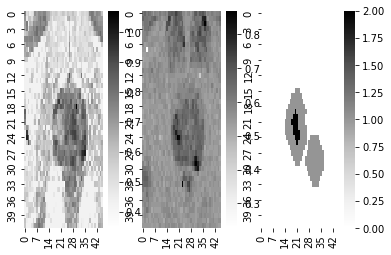

labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/666/lesion1/adc/666_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/666/lesion1/adc/666_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/666/lesion1/adc/666_lesion1_adc_U_OjmNZ8.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/666/lesion3/adc/666_lesion3_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/666/lesion3/adc/666_lesion3_adc_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/666_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/666_lesion1_hbv_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/666_lesion1_hbv_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/666_lesion3_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/666_lesion3_hbv_U_8ekGLQ.n

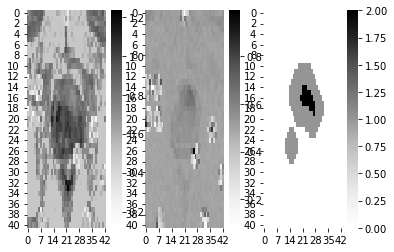

bbbbb 2794  res_bool shape torch.Size([28, 46, 48])  img_shape (28, 46, 48)


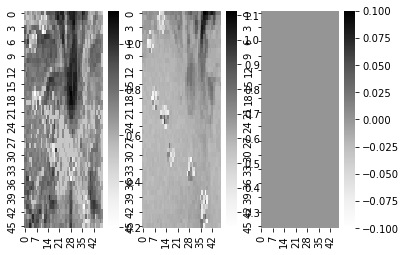

labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/003/lesion1/adc/3_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/003/lesion1/adc/3_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/003/lesion1/adc/3_lesion1_adc_U_OjmNZ8.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/003/lesion2/adc/3_lesion2_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/003/lesion2/adc/3_lesion2_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/003/lesion2/adc/3_lesion2_adc_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/3_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/3_lesion1_hbv_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/3_lesion1_hbv_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/

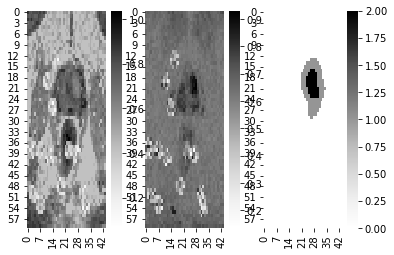

labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/004/lesion1/adc/4_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/004/lesion1/adc/4_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/004/lesion1/adc/4_lesion1_adc_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/4_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/4_lesion1_hbv_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/4_lesion1_hbv_U_OjmNZ8.nii.gz']
ratio 0.3955773955773956
ratio 0.2608695652173913
reduced_sum 2021  reduced_common 42
bbbbb 12537  res_bool shape torch.Size([33, 45, 49])  img_shape (33, 45, 49)


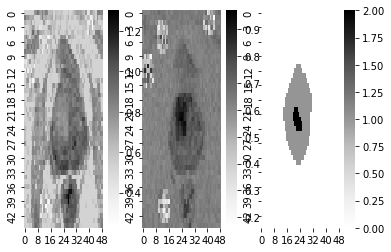

bbbbb 2083  res_bool shape torch.Size([23, 41, 42])  img_shape (23, 41, 42)


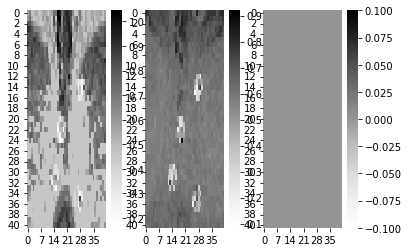

no prostate! 25
no prostate! 17
labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/027/lesion1/adc/27_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/027/lesion1/adc/27_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/027/lesion1/adc/27_lesion1_adc_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/27_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/27_lesion1_hbv_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/27_lesion1_hbv_U_OjmNZ8.nii.gz']
ratio 0.043010752688172046
ratio 0.043010752688172046
reduced_sum 825  reduced_common 93
bbbbb 5559  res_bool shape torch.Size([31, 41, 48])  img_shape (31, 41, 48)


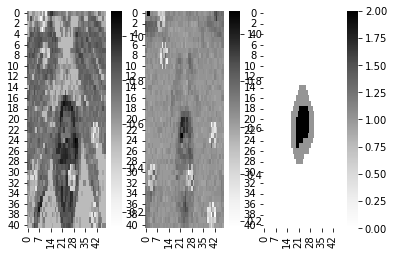

no prostate! 30
labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/046/lesion1/adc/46_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/046/lesion1/adc/46_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/046/lesion1/adc/46_lesion1_adc_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/46_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/46_lesion1_hbv_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/46_lesion1_hbv_U_OjmNZ8.nii.gz']
ratio 0.12
ratio 0.12
reduced_sum 1020  reduced_common 100
bbbbb 1287  res_bool shape torch.Size([25, 43, 47])  img_shape (25, 43, 47)


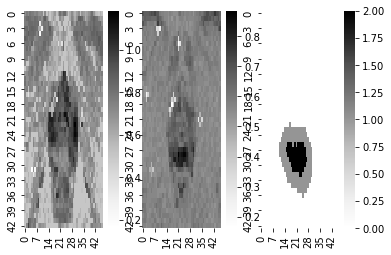

bbbbb 108  res_bool shape torch.Size([33, 51, 56])  img_shape (33, 51, 56)


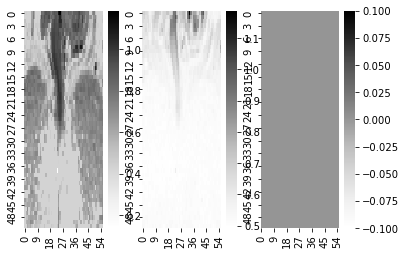

no prostate! 32
labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/055/lesion1/adc/55_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/055/lesion1/adc/55_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/055/lesion1/adc/55_lesion1_adc_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/55_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/55_lesion1_hbv_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/55_lesion1_hbv_U_OjmNZ8.nii.gz']
ratio 0.0
ratio 0.0
reduced_sum 478  reduced_common 44
bbbbb 1559  res_bool shape torch.Size([25, 40, 45])  img_shape (25, 40, 45)


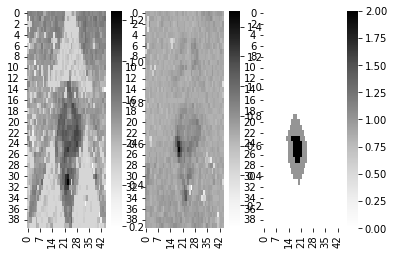

labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/057/lesion1/adc/57_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/057/lesion1/adc/57_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/057/lesion1/adc/57_lesion1_adc_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/57_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/57_lesion1_hbv_U_OjmNZ8.nii.gz']
ratio 0.049019607843137254
ratio 0.049019607843137254
reduced_sum 953  reduced_common 102
bbbbb 1071  res_bool shape torch.Size([31, 45, 52])  img_shape (31, 45, 52)


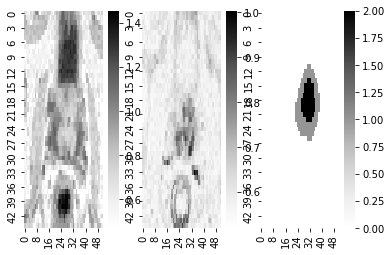

labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/058/lesion1/adc/58_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/058/lesion1/adc/58_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/058/lesion1/adc/58_lesion1_adc_U_OjmNZ8.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/058/lesion2/adc/58_lesion2_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/058/lesion2/adc/58_lesion2_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/058/lesion2/adc/58_lesion2_adc_U_OjmNZ8.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/058/lesion3/adc/58_lesion3_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/058/lesion3/adc/58_lesion3_adc_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJs

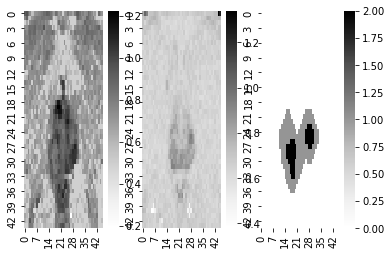

labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/061/lesion1/adc/61_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/061/lesion1/adc/61_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/061/lesion1/adc/61_lesion1_adc_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/61_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/61_lesion1_hbv_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/61_lesion1_hbv_U_OjmNZ8.nii.gz']
ratio 0.3074792243767313
ratio 0.16216216216216217
reduced_sum 1990  reduced_common 18
bbbbb 9523  res_bool shape torch.Size([29, 42, 45])  img_shape (29, 42, 45)


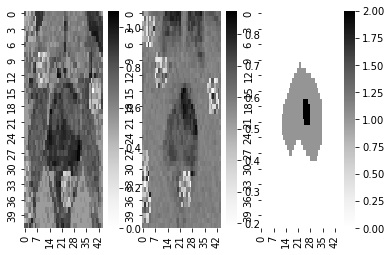

bbbbb 225  res_bool shape torch.Size([25, 42, 46])  img_shape (25, 42, 46)


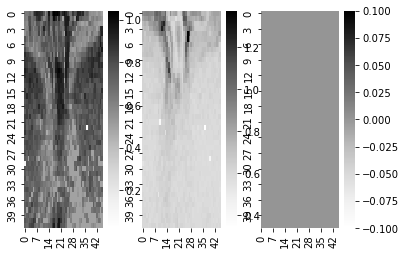

bbbbb 4841  res_bool shape torch.Size([25, 47, 51])  img_shape (25, 47, 51)


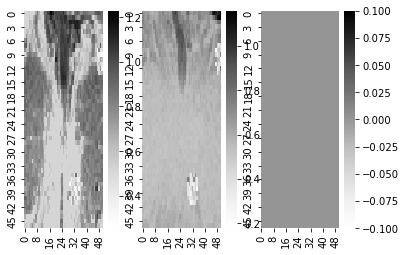

labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/074/lesion1/adc/74_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/074/lesion1/adc/74_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/074/lesion1/adc/74_lesion1_adc_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/74_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/74_lesion1_hbv_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/74_lesion1_hbv_U_OjmNZ8.nii.gz']
ratio 0.25654450261780104
ratio 0.0
reduced_sum 1195  reduced_common 49
bbbbb 866  res_bool shape torch.Size([31, 42, 47])  img_shape (31, 42, 47)


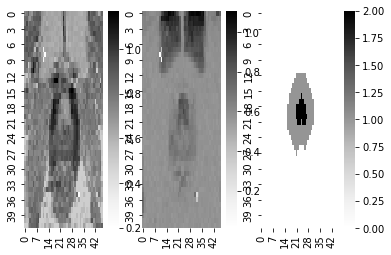

labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/075/lesion1/adc/75_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/075/lesion1/adc/75_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/075/lesion1/adc/75_lesion1_adc_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/75_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/75_lesion1_hbv_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/75_lesion1_hbv_U_OjmNZ8.nii.gz']
ratio 0.39086294416243655
ratio 0.2532467532467532
reduced_sum 1934  reduced_common 39
bbbbb 644  res_bool shape torch.Size([28, 42, 46])  img_shape (28, 42, 46)


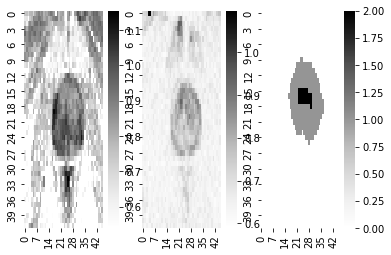

no prostate! 80
labels ['/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/082/lesion1/adc/82_lesion1_adc_U_8ZmM76.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/082/lesion1/adc/82_lesion1_adc_U_8ekGLQ.nii.gz', '/home/sliceruser/workspaces/konwersjaJsonData/AI4AR_cont/Lesion_Labels/082/lesion1/adc/82_lesion1_adc_U_OjmNZ8.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/82_lesion1_hbv_U_8ZmM76.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/82_lesion1_hbv_U_8ekGLQ.nii.gz', '/workspaces/konwersjaJsonData/explore/temp/82_lesion1_hbv_U_OjmNZ8.nii.gz']
ratio 0.039473684210526314
ratio 0.039473684210526314
reduced_sum 680  reduced_common 76
bbbbb 15794  res_bool shape torch.Size([29, 42, 45])  img_shape (29, 42, 45)


KeyboardInterrupt: 

In [68]:

test_ids = pd.read_csv("/workspaces/konwersjaJsonData/test_ids.csv").to_numpy().flatten()

test_ids= list(map(lambda el: str(el).strip(),test_ids ))
filter_ids=lambda row: str(row[1]['masterolds']).strip() not in test_ids
modalities_of_intrest=['t2w','adc','hbv']
cols=sourceFrame.columns
noSegCols=list(filter(lambda el: '_noSeg' in el , cols))+['series_MRI_path']
lesion_cols=list(filter(lambda el: 'lesion' in el , noSegCols))
main_modality = 'adc'
non_mri_inputs=[new_col_name]
out_folder='/workspaces/konwersjaJsonData/explore/temp'
# with mp.Pool(processes = mp.cpu_count()) as pool:
# with mp.Pool(processes = 1) as pool:
#     @curry  
#     def pmap(fun,iterable):
#         return pool.map(fun,iterable)

ids=toolz.pipe(sourceFrame.iterrows()
                                ,filter(lambda row: row[1]['series_desc'] in modalities_of_intrest)
                                ,filter(filter_ids) # filter out all of the test cases
                                ,groupByMaster
                                ,map(partial(iterGroupModalities,modalities_of_intrest=modalities_of_intrest,label_cols=lesion_cols,non_mri_inputs=non_mri_inputs))
                                ,filter(lambda group: ' ' not in group[1].keys() )
                                ,list
                                ,map(partial(visualize_range,main_modality=main_modality,modalities_of_intrest=modalities_of_intrest,non_mri_inputs=non_mri_inputs,out_folder=out_folder))                            
                                ,list)



In [ ]:
aa=sourceFrame['masterolds'].to_numpy()
99461 in aa

In [ ]:
# list(filter(lambda idd: str(idd) in list(map(str,test_ids)), ids))
list(filter(lambda idd: int(idd) in list(map(int,test_ids)) , ids))


In [ ]:
# https://github.com/MIC-DKFZ/nnUNet.git

target_big=torch.zeros((4,4,4)).bool()
res_bool=torch.zeros((4,4,4)).bool()
target_big[1,2,3]=True
target_big[2,2,3]=True
target_big=torch.argwhere(target_big)
# target_big.shape
res_bool[[(0,0, 1, 2), (0,1, 2, 2)]]=True
res_bool